**Содержание темы**

1.  [Теория](https://colab.research.google.com/drive/1Qfic-ckzSmXUZ5pyQ7YDzE_gLq9hIA_T?usp=sharing)
2.  [Практический ноутбук 1](https://colab.research.google.com/drive/1fchXLLvAmJweE3kB00xJQazp2DiA_2Be?usp=sharing)
3. Практический ноутбук 2

## Планирование

Обучение с подкреплением используют не только для игр или управления роботами. Эту стратегию часто применяют для решения многих других задач, в том числе и планирования. Планирование — это задача составления расписания. Например, это может быть расписание работы конвейера. Нужно решить, как расположить машины и что они будут делать в заданное время, чтобы оптимизировать процесс. 

В этом уроке рассмотрим гипотетическую задачу: составление расписания работы сотрудников в компании. Для примера возьмем график работы кураторов УИИ. 


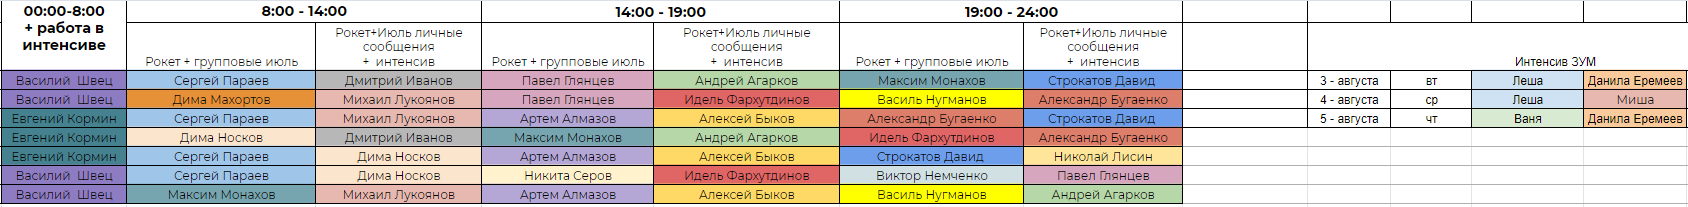

У каждого куратора есть различные характеристики, которые решают, когда они могут или не могут выходить на работу. Это:

* выходные дни;
* отпуски;
* предпочитаемые часы работы;
* разные часовые пояса;
* назначенные встречи/прочие дела;
* разные ставки работы (полставки/полная ставка).

Все эти характеристики могут меняться из недели в неделю, поскольку у человека меняется расписание. Нужно составить расписание, которое учитывает все это. Причем желательно делать это не вручную, а через алгоритм ИИ.

*Примечание: этот алгоритм только демонстрирует возможности составления расписания и не используется на практике.*

Импортируем все нужные модули и библиотеки, подключаемся к диску.

In [ ]:
# Библиотека TensorFlow
import tensorflow as tf     

# Библиотека NumPy
import numpy as np   

# Модуль для генерации рандомных значений
import random  

# Модуль для сохранения результатов в файл
import pickle     

# Модуль для работы с картинками и видео (нужен для предобработки данных и записи результата)
import cv2      

import random

# Список, где автоматически удаляются старые значения при добавлении новых, чтобы память не переполнилась
from collections import deque   

# Модуль pyplot из библиотеки Matplotlib
import matplotlib.pyplot as plt 

# Функции для создания и загрузки модели из TensorFlow
from tensorflow.keras.models import load_model, Model, Sequential 

# Слои из Keras
from tensorflow.keras.layers import * 

# Оптимизатор RMSprop
from tensorflow.keras.optimizers import RMSprop  

# Модуль для бэкэнда Keras
from tensorflow.keras import backend as K     

# Функция для удобного onehot энкодинга
from tensorflow.keras.utils import to_categorical                 

# Модуль для сохранения результатов в файл
import pickle  

# Импортируем модуль, который помогает очищать вывод из ячейки Colab
from google.colab import output       

## Создание среды

Дальше создаем класс, который инициализирует среду. В данном случае среда — это пустой график, который нужно заполнить дежурными работниками. Работа идет семь дней в неделю, на протяжении дня есть четыре смены. На протяжении всего дня семь людей должны выйти на работу, кроме дней с интенсивами, когда выходит девять людей (интенсивы происходят ровно три раза в неделю).

Заполнение графика можно интерпретировать как игру, за которую назначаются награды. Логика этой псевдоигры, а также код для назначения наград, описаны ниже.

Объявляем класс для создания среды:


In [ ]:
class schedule_environment:

  def __init__(self, 
               algorithm, 
               min_curators = 28, 
               max_curators = 32):
    
    ''' Функция инициализации
    Принимает на вход алгоритм (его описание будет позже) и количество минимальных и максимальных работников, 
    на который предназначен алгоритм

    Аргументы:
    algorithm - 
    min_curators - 
    max_curators -

    '''
    # Записываем алгоритм в объект класса
    self.algorithm = algorithm                                        
    
    # Записываем количество минимальных кураторов в объект класса
    self.min_curators = min_curators 

    # Записываем количество максимальных кураторов в объект класса                                 
    self.max_curators = max_curators       

    # Записываем количество максимальных кураторов в объект класса                           
    self.num_curators = np.random.randint(min_curators, max_curators) 

    # В таблице есть 7 рядов, т. к. УИИ работает 7 дней в неделю
    self.num_rows = 7  

    # В таблице есть 9 столбцов, т. к. кураторы выходят на дежурство максимум 9 раз в день       
    self.num_cols = 9         
    
    # Инициализиуем все значения в таблице как -2 (-2 значит не заполнено)
    self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2   

 
  def get_random_schedule(self, 
                          days_good, 
                          times_bad): 

    ''' Функция создания расписания куратора — куратор отмечает, когда он хочет работать и когда не может.
    На текущий момент это расписание создается полностью рандомным образом, без учета часового пояса 
    или количества востребованных кураторов на время дня.

    Аргументы:
    days_good — смены, когда куратор предпочитает дежурить
    times_bad — смены, когда не может

    '''                          
    
    # Инициализируем расписания куратора нулями (7 дней в неделю, 4 смены в день), 0 — я могу в это время 
    time_schedule = np.zeros((7, 4))  
    
    # Инициализируем список, куда будем добавлять индексы ячеек, описывающие, когда куратор предпочитает или не может дежурить
    previously_accessed_indices = []  
    
    # i — это счетчик, с помощью которого мы используем while-цикл
    i = 0  

    # В while-цикле рандомным образом выбираем смены, когда куратор предпочитает дежурить  
    while i < days_good:  

      # Генерируем рандомный индекс из таблицы         
      x_index, y_index = np.random.randint(0, time_schedule.shape[0]), np.random.randint(0, time_schedule.shape[1]) 

      # Если смена не помечена, продолжаем с ней работать (иначе, если ее индекс уже был выбран, цикл сгенерирует новый индекс)
      if (x_index, y_index) not in previously_accessed_indices:  

        # Добавляем индекс смены в таблицу    
        previously_accessed_indices.append((x_index, y_index))     

        # Записываем значения индекса в 1 (что значит, куратор предпочитает дежурить в это время) 
        time_schedule[x_index, y_index] = 1                        
        
        # Увеличиваем счетчик i на единицу
        i += 1 

    i = 0      

    # В while-цикле рандомным образом выбираем смены, когда куратор не может дежурить
    while i < times_bad:  

      # Генерируем рандомный индекс из таблицы
      x_index, y_index = np.random.randint(0, time_schedule.shape[0]), np.random.randint(0, time_schedule.shape[1]) 

      # Если смена не помечена, продолжаем с ней работать (иначе, если ее индекс уже был выбран, цикл сгенерирует новый индекс)
      if (x_index, y_index) not in previously_accessed_indices:

        # Добавляем индекс смены в таблицу       
        previously_accessed_indices.append((x_index, y_index))  

        # Записываем значения индекса в -1 (что значит, куратор не может дежурить в это время)   
        time_schedule[x_index, y_index] = -1      

        i += 1                                                                                  

    # Создаем новую таблицу. В этой таблице будут 9 смен, которые пересекаются по времени (9 временных промежутков) 
    shift_schedule = np.zeros((self.num_rows, self.num_cols))                                        
    
    # Создаем словарь с индексами новой и старой таблиц (0 — ночь, один куратор; 1 — утро, два куратора; 2 — обед, два куратора; 3 — вечер, четыре куратора, 2 из которых на интенсивах)
    indices_map = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3} 
    
    # Итерируем по словарю, чтобы записать новые значения в новую таблицу
    for i, j in indices_map.items():     

      # Записываем новые значения в таблицу графика куратора         
      shift_schedule[:, i] = time_schedule[:, j] 
    
    # Возвращаем график, который отображает, на каких сменах куратор может или не может дежурить
    return shift_schedule  

  
  def create_curator(self):

    ''' Функция генерирует данные о кураторе: 
часовой пояс, график, когда он предпочитает/не может дежурить, работает на полную ставку или на полставки

    '''    
    
    # Создаем пустой список, где будет содержаться вся описательная информация о кураторе
    traits_list = []               
    
    # Часовой пояс куратора рандомно генерируется от 1 до 24
    preferred_time = preferred_time = random.randint(1, 24)  
    
    # Записываем часовой пояс куратора в список характеристик
    traits_list.append(preferred_time)                       

    # С 10% вероятностью куратор будет полставочником, с 90% вероятностью будет работать на полную ставку
    work_type = np.random.choice(['пол ставки', 'полная ставка'], p = (0.1, 0.9)) 
    
    # Заменяем строку на 0.5 (значит полставки) или 1 (значит полная ставка)
    traits_list.append(0.5 if work_type == 'пол ставки' else 1) 
    
    # Кураторы, которые работают на полную ставку, должны быть готовы выходить на дежурство минимум 3 раза в неделю, и не могут быть заняты больше чем 5 раз в неделю
    if work_type == 'полная ставка':   
      
      # Куратор будет готов дежурить от 3 до 7 раз в неделю
      num_good_days = random.randint(3, self.num_rows)     
      
      # Куратор будет занят от 0 до 5 раз в неделю
      num_bad_times = random.randint(0, self.num_rows - 2) 
    
    # Кураторы, которые работают на полставки, должны быть готовы выходить на дежурство минимум 1 раз в неделю, и не могут быть заняты больше чем 7 раз в неделю
    else:    
      
      # Куратор будет готов дежурить от 1 до 7 раз в неделю
      num_good_days = random.randint(1, self.num_rows)     
      
      # Куратор будет занят от 0 до 7 раз в неделю
      num_bad_times = random.randint(0, self.num_rows)     

    # Используя ранее объявленную функцию, генерируем график, который описывает, когда куратор может или не может дежурить
    curator_timetable = self.get_random_schedule(num_good_days, num_bad_times) 
    
    # Добавляем график в список данных о кураторе
    traits_list.append(curator_timetable) 

    # Превращаем список в массив и возвращаем
    return np.array(traits_list)   


  def get_curator_stats(self): 
      
    '''  Функция генерирует информацию для всех кураторов, которые работают в предприятии (итоговые данные можно рассматривать как среду)
     Данные будут храниться в нескольких многомерных массивах, где разные каналы массива будут содержать информацию для разных кураторов 
     Данные для кураторов инициализируются как -2 потому, что массив резервирует места для всех кураторов. Даже если кто-то на отпуске/ушел/есть свободная вакансия. 
     Идея в том, чтобы нейронная сеть работала при разном количестве работников, но не ставила на дежурства людей, которых нет. 
    
    '''

    # Рандомно инициализируем количество кураторов, которые могут работать
    self.num_curators = random.randint(self.min_curators, self.max_curators) 

    self.timezone_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2
    
    # Инициализируем массив, который содержит информацию о виде работы куратора (полставки или полная ставка) как -2
    self.employment_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2    
    
    # Инициализиуем массив с предпочитаемым временем работы кураторов как -2
    self.schedule_stats = np.ones((1, self.num_rows, self.num_cols, self.max_curators)).astype(np.float32) * -2 
    
    # Генерируем данные для всех кураторов используя выше созданную функцию внутри list comprehension
    curator_stats = [self.create_curator() for i in range(self.num_curators)] 

    # В цикле переписываем данные из выше созданного списка в NumPy-массивы
    for i in range(self.num_curators):                       
      
      # Перезаписываем данные о временном поясе из списка в NumPy-массив
      self.timezone_stats[:, i] = curator_stats[i][0]        
      
      # Перезаписываем данные о виде работы из списка в NumPy-массив
      self.employment_stats[:, i] = curator_stats[i][1]      
      
      # Перезаписываем данные о графике предпочитаемого времени работы из списка в NumPy-массив
      self.schedule_stats[:, :, :, i] = curator_stats[i][2]  
    
    # Считаем рабочую силу личного состава (полставочник считается за половину работника, обычный работник считается как 1 работник). Это используется позже.
    self.available_manpower = 0.5 * self.employment_stats[self.employment_stats == 0.5].size + self.employment_stats[self.employment_stats == 1].size 


  def get_reward(self, 
                 i, 
                 j):
      
    '''   Функция возвращает награды за различные действия. 
    Награда состоит из суммы трех компонентов, известных как альфа-метрика, бета-метрика и дельта-метрика.
    Альфа-, бета-, и дельта-метрики — произвольные названия. Они созданы, чтобы отслеживать работу нейронной сети.  
    Данная функция вызывается после каждого действия (когда куратор ставится на дежурство во временном промежутке), 
    что значит — награды непрерывные.
          
    Аргументы:
    i -  
    j - 
    
    '''  

    # Индекс куратора — это его номер (от 0 до max_curator)
    curator_index = int(self.duty_timetable[i, j])   
    
    # Награда инициализируется нулем
    reward = 0                                       

    # Метрика альфа — награда за расписание (положительная, если алгоритм ставит кураторов на дежурство в удобное для них время, отрицательная, если ставит, когда они не могут работать).
    
    # Считаем альфа-метрику
    alpha_metric = self.get_schedule_reward(self.schedule_stats[0, i, j, curator_index]) 
    # Добавляем альфа-метрику в награду
    reward += alpha_metric                 
    # Увеличиваем значение метрики за эпизод (self.alpha_metric_batch объявляется в коде ниже)
    self.alpha_metric_batch += alpha_metric      

    # Бета-метрика - награда за временной промежуток (положительная если алгоритм ставит кураторов на дежурство 'днем', иначе отрицательная)

    # Считаем бета-метрику
    beta_metric = self.get_timezone_reward(self.timezone_stats[0, curator_index], j) 
    # Добавляем бета-метрику в награду
    reward += beta_metric                        
    # Увеличиваем значение метрики за эпизод (self.beta_metric_batch объявляется в коде ниже)
    self.beta_metric_batch += beta_metric        

    # Дельта-метрика всегда будет отрицательной. Она отвечает за количество косяков, которые делает алгоритм 
    # (если ставит одного куратора на дежурство слишком часто, больше чем 1 раз за день, или если данный куратор в отпуске)
    
    # Считаем дельта-метрику (из-за функции, с которой она задается, эта метрика будет ниже 0, даже если все сделано отлично, но она будет еще ниже, если есть много косяков)
    delta_metric = self.get_times_used_reward(curator_index, i, j) 
    # Добавляем дельта-метрику в награду
    reward += delta_metric                       
    # Увеличиваем значение метрики за эпизод (self.delta_metric_batch объявляется в коде ниже)
    self.delta_metric_batch += delta_metric      
    
    # Возвращаем награду, которая является суммой: alpha_metric + beta_metric + delta_metric
    return reward         # Возвращаем награду, которая является суммой: alpha_metric + beta_metric + delta_metric

  
  def get_schedule_reward(self, 
                          element): 
                          
    ''' Функция для извлечения награды по расписанию (метрика альфа)
        
    Аргументы: 
    element - ячейка из расписания куратора  
    
    '''        
  
    # Если элемент таблицы равен 1, это значит алгоритм поставил куратора работать в удобное ему время
    if element == 1:   
      # За это назначается награда +1
      reward = 1       
    
    # Если элемент таблицы равен -1, это значит алгоритм поставил куратора работать, когда он не может или ему не удобно работать в это время
    elif element == -1:   
      # За это назначается награда -1
      reward = -2         
    
    # Иначе, элемент таблицы равен 0, что значит куратору без разницы работать в это время
    else:          
      # За это дается нулевая награда
      reward = 0   
    
    # Возвращаем награду
    return reward   


  def get_timezone_reward(self, element, timeslot): 
      
    ''' Функция для извлечения награды по временному поясу (это бета-метрика)
        
    Аргументы: 
    element — ячейка из расписания куратора  
    timeslot — ячейка таблицы, которая отвечает за час дежурства
    
    '''  

    # Если значение timeslot меньше 0, это значит, что куратор отсутствует — возвращаем нулевую награду (другая функция в таком случае даст отрицательную награду)
    if timeslot < 0:    
      return 0
    
    # Если значение timeslot равно 0, он начнет работать в 0:00 по МСК (ночью)
    if timeslot == 0: local_time = 0         
    
    # Если значение timeslot равно 1 или 2, он начнет работать в 8:00 по МСК (утро)
    elif timeslot in [1, 2]: local_time = 8  
    
    # Если значение timeslot равно 3 или 4, он начнет работать в 14:00 по МСК (день)
    elif timeslot in [3, 4]: local_time = 14 
    
    # Иначе это вечернее дежурство, которое начинается в 19:00 по МСК (вечер)
    else: timeslot = 19                      

    # Награда назначается следующей функцией, если удобное время, которое обозначил куратор, близко к времени, когда назначил алгоритм, награда положительная. Иначе она отрицательная.
    reward = 0.15 + -0.002 * min(element - timeslot, element - (24 - timeslot))**2 
    
    # Сжимаем награду от -0.1 до +0.1. Величина этой награды маленькая, т. к. часовой пояс может не соответствовать тому времени, когда куратор говорит, что ему удобно дежурить (оба параметра задаются рандомно). В таком случае сеть должна отдавать приоритет времени, который обозначает куратор.
    return np.clip(reward, -0.1, 0.1)   

  
  def get_times_used_reward(self, curator_index, i, j):    

    ''' Функция для извлечения награды по сильным косякам (это дельта-метрика, и она всегда отрицательная)
        
    Аргументы: 
    curator_index — номер куратора (от 0 до max_curators) 
    i, j — индексы ячейки таблицы графика
    
    '''       

    reward = 0
    
    # Узнаем, на какую ставку работает куратор (полставки или полная ставка) или в принципе не работает
    curator_type = self.employment_stats[0, curator_index] 
    
    # Если значения куратора меньше 0, это значитб что куратора нет в составе
    if curator_type < 0:                 
      
      # В таком случае возвращаем отрицательную награду -2
      return -2                          

    # Извлекаем индекс куратора из таблицы расписания (от 0 до max_curators)
    curator = self.duty_timetable[i, j]  
    
    # Количество раз, которое позволено куратору быть на дежурстве (считается, чтобы рабочая нагрузка распределялась равномерно, и чтобы работники на полставки работали в 2 раза меньше, чем на полную ставку).
    num_times_allowed = curator_type * (self.duty_timetable.size - 8) / self.available_manpower 

    # Считаем, сколько раз куратор уже был поставлен на дежурство
    times_on_duty = (self.duty_timetable == curator).sum() 
    
    # Если куратор был поставлен на дежурство больше чем один раз в день:
    if (self.duty_timetable[i, :] == curator).sum() > 1:   
      
      # Назначаем большую отрицательную награду, -2
      reward = -2 * (self.duty_timetable[i, :] == curator).sum()  
      
      return reward

    # Если куратор уже поставлен на дежурство больше раз, чем он должен работать
    elif times_on_duty > num_times_allowed:                       
      
      # Задается отрицательная награда: чем больше куратор уже дежурит, тем больше отрицательная величина награды (важно, поскольку times_on_duty не целое число, это всегда приведёт к хотя бы небольшой отрицательной награде).
      reward = -0.2 * float((times_on_duty - num_times_allowed))  
    
    reward += 1
    
    # Возвращаем подсчитанную награду
    return reward    


  def create_schedule(self, 
                      train_mode = True, 
                      episodes_in_batch = 50):
      
    ''' Функция, в которой алгоритм будет создавать график работы на неделю. Это можно рассматривать как аналог игрового цикла.
    В одном эпизоде всего 55 действий, что довольно мало в качестве размера пакета для обучения. 
    Поэтому алгоритм будет играть много эпизодов и затем совершать одну итерацию обучения.
        
    Аргументы: 
    train_mode — алгоритм обучается или используется для теста
    episodes_in_batch — отвечает за количество эпизодов, которые пройдут до того, как обучается алгоритм
    
    '''

    # Список временных поясов кураторов — является составной частью состояния
    timezones = []         
    
    # Список вида работы кураторов (полуставка или полная ставка) — является составной частью состояния
    employments = []       
    
    # Список расписаний кураторов (трехмерная матрица, которая содержит двумерный график для каждого куратора) — является составной частью состояния
    schedules = []         
    timetables = []
    
    # Список действий за эпизод (действие — назначения работника на дежурство)
    episode_actions = []   
    
    # Список наград, которые получены за каждое действие
    all_rewards = []       

    # Инициализируем значение альфа-метрики за пакет эпизодов как 0
    self.alpha_metric_batch = 0  
    
    # Инициализируем значение бета-метрики за пакет эпизодов как 0
    self.beta_metric_batch = 0   
    
    # Инициализируем значение дельта-метрики за пакет эпизодов как 0
    self.delta_metric_batch = 0  
    
    # В цикле обнуляем и создаем таблицу много раз
    for episode in range(episodes_in_batch):   
      
      # Инициализируем награды за эпизод пустым списком
      episode_rewards = []    

      # Инициализируем график работы всех кураторов значениями -2 (если -2 не будет позже заполнен, это обозначает, что куратор отсутствует)
      self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2  
      
      # Вызываем функцию, которая генерирует рандомное количество кураторов, их часовые пояса, виды работы и предпочитаемое время работы.
      self.get_curator_stats()         
      
      # Циклом итерируем через ряды (дни) в графике
      for i in range(self.num_rows):   
        
        # Циклом итерируем через столбцы (окна дежурств) в графике
        for j in range(self.num_cols): 
          
          # Убираем окна из дней, когда нет интенсивов
          if not (j >= 3 and i >= 7): 
            
            # Создаем график, который будет подаваться в нейронную сеть. Этот график — трехмерный тензор, который получается при склеивании графика дежурств 
            # (duty_timetable) с графиками удобных и неприемлемых времен всех кураторов
            graph = np.append(self.duty_timetable.copy().reshape(1, self.num_rows, self.num_cols, 1), self.schedule_stats.copy(), axis = 3) 
            
            onehot_timetable = tf.keras.utils.to_categorical([self.duty_timetable], self.max_curators + 2)

            # Полное состояние — это кортеж из выше созданного графика, а также списки временных поясов и виды занятости всех работников
            state = (self.timezone_stats, self.employment_stats, self.schedule_stats, onehot_timetable) 
            
            # Если алгоритм обучается
            if train_mode: 
              
              # Извлекаем действие (какого куратора поставить на дежурство в ячейку (i, j) по заданному состоянию), используя рандомные вероятности
              action = self.algorithm.get_train_action(state) 
            
            # Иначе (алгоритм уже обучен, и он используется при тесте):
            else:          
              
              # Извлекаем действие (какого куратора поставить на дежурство в ячейку (i, j) по заданному состоянию) выбирая классификацию с максимальной вероятности
              action = self.algorithm.get_test_action(state) 

            # Записываем действие (то есть, выбранного куратора) в график всех дежурств
            self.duty_timetable[i, j] = action 
            
            # Используем ранее заданную функцию, чтобы извлечь награду за действие
            reward = self.get_reward(i, j)     
            
            # Записываем массив временных поясов кураторов в список (это часть состояния)
            timezones.append(self.timezone_stats[0])     
            
            # Записываем массив ставок кураторов в список (это часть состояния)
            employments.append(self.employment_stats[0]) 
            
            # Записываем частично заполненный график дежурств и графики готовности на работу всех кураторов в список (это часть состояния)
            schedules.append(self.schedule_stats[0])     
            timetables.append(onehot_timetable[0])
            
            # Записываем действие в список
            episode_actions.append([action])   
            
            # Записываем награду в список
            episode_rewards.append(reward)     

      # Предобрабатываем награды за эпизод (нужно предобрабатывать награды за эпизод отдельно, чтобы слгоритм не воспринимал разные эпизоды как часть одной последовательности при обработки наград)
      episode_rewards = self.algorithm.preprocess_rewards(episode_rewards) 
      
      # all_rewards и episode_rewards оба списки, в этой строке кода мы конкатенируем списки
      all_rewards += episode_rewards 

    # Считаем сумму наград за все эпизоды в пакете (используется в качестве метрики)
    total_reward = np.array(all_rewards).sum() 

    # Возвращаем массивы состояний (timezones, employments, schedules, timetables), действий (episode_actions), наград (all_rewards), и сумму наград (total_reward)
    return timezones, employments, schedules, timetables, episode_actions, all_rewards, total_reward  

##Создание алгоритма

Дальше создаем самописный класс, который будет содержать нейронную сеть, ее гиперпараметры, а также логику для инференса и обучения нейронной сети. Ранее созданный класс среды будет также содержаться внутри этого класса.

In [ ]:
# Создаем класс алгоритма
class REINFORCE:
  
  def __init__(self, 
               gamma = 0.95, 
               load_pretrained = False):

    '''          
    Аргументы: 
    gamma - значение Гамма
    load_pretrained - если = False, обучение происходит с нуля. Иначе, обучение продолжается с предыдущего сохранения
    
    '''

    # Записываем среду внутри объекта алгоритма. Подаем self в объект, чтобы можно было обращаться к алгоритму в объекте среды
    self.environment = schedule_environment(self) 
    
    # Записываем значение гаммы в объект
    self.gamma = gamma               
    
    # Записываем размер шага обучения в объект
    self.learning_rate = 1e-4        
    
    # Создаем модель через функцию (которая объявляется внутри класса), записываем модель в объект
    self.model = self.create_model() 
    
    # Создаем массив наград за все эпизоды (используется в качестве метрики)
    self.rewards = []                
    
    # Создаем массив альфа-метрик за все эпизоды (используется в качестве метрики)
    self.alpha_metrics = []          
    
    # Создаем массив бета-метрик за все эпизоды (используется в качестве метрики)
    self.beta_metrics = []           
    
    # Создаем массив дельта-метрик за все эпизоды (используется в качестве метрики)
    self.delta_metrics = []          

    # Записываем директорию, куда будут сохраняться веса модели и массивы метрик
    self.save_directory = '/content/reinforce_schedule/' 

    # Если продолжаем обучения:
    if load_pretrained:   
      
      # Вызываем функцию которая сохраняет веса модели и записанные метрики за эпизоды
      self.load_results() 

 
  def preprocess_rewards(self, 
                         rewards): 

    ''' Функция для предобработки наград (непрерывные награды). 
    Эта функция принимает на вход список сырых наград и возвращает обработанные награды.   

    Аргументы: 
    rewards — список сырых наград
    
    '''

    # Инициализируем новый массив нулями, куда будем записывать предобработанные награды
    processed_rewards = np.zeros_like(rewards).astype(np.float32) 
    
    # Инициализируем значение скользящей суммы нулём
    running_add = 0 
    
    # Проходимся через массив наград в обратном порядке
    for i in reversed(range(0, len(rewards))): 
      
      # sum * y (gamma) + reward (псевдо-уравнения Беллмана)
      running_add = running_add * self.gamma + rewards[i] 
      
      # Устанавливаем значение награды в соответствии с уравнением Беллмана
      processed_rewards[i] = running_add         
    
    # Возвращаем одномерный список наград
    return processed_rewards.flatten().tolist()  

 
  def get_train_action(self, 
                       state):

    ''' Функция инференса, с помощью которой алгоритм сети будет принимать решение рандомным образом, используя предсказанные вероятности нейросети

    Аргументы: 
    state -  
    
    '''

    # Нейронная сеть предсказывает вероятности принятия всех действий по состоянию
    probabilities = self.model.predict(state) 
    
    # Затем алгоритм рандомно выбирает действия, используя заданные вероятности
    result = np.random.choice(np.arange(self.environment.max_curators), p = probabilities.flatten()) 
    
    # Возвращаем выбранное действие
    return result 

  
  def get_test_action(self, 
                      state):

    ''' Функция 

    Аргументы: 
    state -  
    
    '''      
    
    probabilities = self.model.predict(state)

    return np.argmax(probabilities)

  
  def create_model(self):

    ''' Функция создания нейронной сети — нейронная сеть имеет четыре входа 
    (у состояния есть четыре составные части — часовые пояса работников, рабочая ставка, 
    предпочитаемое время работы кураторов и заполненный график работы всех кураторов). 
    
    ''' 

    preferred_time_branch = Input((self.environment.max_curators,))                                                     # Ветка, которая принимает на вход временные пояса работников (часть состояния)
    worktype_branch = Input((self.environment.max_curators,))                                                           # Ветка, которая принимает на вход вид работы соотрудников (часть состояния)
    schedules_branch = Input((self.environment.num_rows, self.environment.num_cols, self.environment.max_curators))     # Ветка, которая принимает на вход личные расписания соотрудников (часть состояния)
    timetable_branch = Input((self.environment.num_rows, self.environment.num_cols, self.environment.max_curators + 2)) # Ветка, которая принимает на вход график дежурств, который заполняется в эпизоде (часть состояния)

    x3 = Flatten()(schedules_branch)                                                                 # Выравниваем массив графиков соотрудников, чтобы затем можно было конкатенировать с остальными ветками
    x4 = Flatten()(timetable_branch)                                                                 # Выравниваем массив расписания за неделю, чтобы затем можно было конкатенировать с остальными ветками

    x = concatenate([preferred_time_branch, worktype_branch, x3, x4])                                # Конкатенируем все четыре входные ветки в одну
    x = Dense(512, activation = 'elu')(x)                                                            # Добавляем один полносвязанный слой с активационной функции elu
    out = Dense(self.environment.max_curators, activation = 'softmax')(x)                            # Добавляем выходной слой с max_curators количеством нейронов (сетка может выбрать любого работника на дежурство)
    model = Model([preferred_time_branch, worktype_branch, schedules_branch, timetable_branch], out) # Создаем модель используя функциональный API
    
    # Компилируем модель, используем RMSprop в качестве оптимизатора и низкий шаг обучения
    model.compile(optimizer = RMSprop(learning_rate = self.learning_rate), loss = 'sparse_categorical_crossentropy') 
    
    # Функция возвращает компилированную модель
    return model   


  def save_results(self):

    ''' Функция сохранения прогресса обучения. 
    Функция сохраняет модель, а также ранее полученные метрики ''' 

    # Сохраняем модель в файл
    self.model.save(self.save_directory + 'neural_network.h5')    
    
    # Открываем текстовый файл, куда будем записывать значения ранее полученных метрик
    with open(self.save_directory + 'rewards_array', 'wb') as f:  
      
      # Сохраняем метрики в файл.
      pickle.dump([self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics], f) 

   
  def load_results(self):

    ''' Функция загрузки ранее сохраненной модели и значения метрик, чтобы можно было продолжать обучение ''' 

    # Загружаем модель из директории, где она сохранена
    self.model = load_model(self.save_directory + 'neural_network.h5') 
    
    # Открываем текстовый файл, который содержит ранее сохраненные метрики
    with open(self.save_directory + 'rewards_array', 'rb') as f:  

      # Загружаем метрики в переменные, чтобы можно было выводить график за все обучение
      self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics = pickle.load(f) 

  
  def train_algorithm(self, 
                      episodes_in_batch = 20, 
                      train_times = 1000):
      
    ''' Функция обучения алгоритма. Будет использовать ранее созданную функцию для проигрывания эпизода, которая содержится внутри класса environment.
    Очень важно, чтобы количество эпох в эпизоде было достаточно большим, потому что иначе будет слишком маленький размер пакетов данных для стабильного обучения алгоритма.

    Аргументы: 
    episodes_in_batch — количество эпизодов в одном пакете (эпохе)
    train_times — количество эпох обучения
    
    '''     

    # В цикле обучаемся нужное количество раз
    for i in range(train_times): 
      
      # Вызываем функцию проигрывания эпизода и получаем состояния, действия и награды из эпизода
      timezones, employments, schedules, timetables, episode_actions, all_rewards, total_reward = self.environment.create_schedule(episodes_in_batch = episodes_in_batch) 
      
      # Записываем сумму наград и метрик за пакет эпизодов в списки. Это делается для отображения графиков.
      
      self.rewards.append(total_reward)                                  # общих наград за пакет эпизодов в список
      self.alpha_metrics.append(self.environment.alpha_metric_batch)     # альфа-метрик за пакет эпизодов в список
      self.beta_metrics.append(self.environment.beta_metric_batch)       # бета-метрик за пакет эпизодов в список
      self.delta_metrics.append(self.environment.delta_metric_batch)     # дельта-метрик за пакет эпизодов в список
      
      # Переводим все полученные данные в NumPy-массивы, устанавливаем тип данных float32
      
      timezones = np.array(timezones).astype(np.float32)               # часовых поясов в NumPy-массив с dtype float32
      employments = np.array(employments).astype(np.float32)           # ставок в NumPy-массив с dtype float32
      schedules = np.array(schedules).astype(np.float32)               # расписаний работников в NumPy-массив с datatype float32
      timetables = np.array(timetables).astype(np.float32)             # заполненных графиков дежурств в NumPy-массив с datatype float32
      episode_actions = np.array(episode_actions).astype(np.float32)   # действий (решений нейронной сети) в NumPy-массив с datatype float32
      all_rewards = np.array(all_rewards)

      # Обучаем нейронную сеть, используя состояния, действия нейронной сети и награды
      self.model.train_on_batch([timezones, employments, schedules, timetables], episode_actions, sample_weight = all_rewards)

      # Раз в десять эпизодов отображаем графики наград и сохраняем прогресс
      if i % 10 == 0: 
        
        # Используем функцию (которая объявлена чуть позже) чтобы отобразить график обучения
        show_rewards(self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics) 
        
        # Сохраняем прогресс обучения
        self.save_results()           

Ниже написанный код содержит функцию для отображения графиков с историей наград и метрик. Мы можем узнать, как хорошо и как быстро обучается алгоритм, посмотрев на скользящее среднее от награды и метрик.

In [ ]:
def moving_average(data, 
                   width = 100): 

  ''' Функция подсчета скользящих средних значений из массива

  Аргументы: 
  data - входной массив
  width - длина на которое считаем скользящее средне
    
  '''    

  # Длина свертки (минимум из заданной длины свертки и длины датасета)
  width = min(width, len(data))         
  
  # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)
  data = np.concatenate([np.repeat(data[0], width), data])    
  
  # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
  return np.convolve(data, np.ones(width), 'valid') / width   

# Создаем функцию для 
def show_rewards(episode_rewards, 
                 alpha_metrics, 
                 beta_metrics, 
                 delta_metrics):

  ''' Функция отображения награды и метрик за пакеты эпизодов. 
  
  Аргументы: все метрики, которые требуется отобразить.
  episode_rewards, 
  alpha_metrics, 
  beta_metrics, 
  delta_metrics
    
  '''

  # Сначала удаляем предыдущий вывод (это делается, чтобы не было переполнения памяти огромным количеством графиков).
  output.clear() 
  
  # Создаем большой размер полотна
  fig, axes = plt.subplots(2, 2, figsize = (20, 10)) 
  
  axes[0,0].plot(episode_rewards, color = 'blue', linestyle = '--', label = 'Награда за итерацию (после обработки)')          # Выводим график наград за пакет эпизодов
  axes[0,0].plot(moving_average(episode_rewards), color = 'red', label = 'Скользящее среднее награды (после обработки)')      # Выводим скользящее среднее наград
  axes[0,0].axhline(y = 0, color='k', linestyle='-')                                                                          # Рисуем горизонтальную линию на y = 0 (чтобы понять какие награды выше/ниже нуля).
  axes[0,0].set_xlabel('Эпоха обучения')                                                                                      # Устанавливаем лейблы осей
  axes[0,0].set_ylabel('Значение награды')                                                                                    # Устанавливаем лейблы осей
  axes[0,0].legend()                                                                                                          # Создаем легенду.

  axes[0,1].plot(alpha_metrics, color = 'green', linestyle = '--', label = 'Награда за итерацию (график по желанию)')         # Выводим график альфа-метрик за пакет эпизодов
  axes[0,1].plot(moving_average(alpha_metrics), color = 'orange', label = 'Скользящее среднее награды (график по желанию)')   # Выводим скользящее среднее альфа-метрик
  axes[0,1].axhline(y = 0, color='k', linestyle='-')                                                                           
  axes[0,1].set_xlabel('Эпоха обучения')                                                                                       
  axes[0,1].set_ylabel('Значение награды')                                                                                     
  axes[0,1].legend()                                                                                                           

  axes[1,0].plot(beta_metrics, color = 'blueviolet', linestyle = '--', label = 'Награда за итерацию (временной пояс)')        # Выводим график бета-метрик за пакет эпизодов
  axes[1,0].plot(moving_average(beta_metrics), color = 'gold', label = 'Скользящее среднее награды (временной пояс)')         # Выводим скользящее среднее бета-метрик
  axes[1,0].axhline(y = 0, color='k', linestyle='-')                                                                           
  axes[1,0].set_xlabel('Эпоха обучения')                                                                                       
  axes[1,0].set_ylabel('Значение награды')                                                                                     
  
  axes[1,0].legend()                                                                                                           

  axes[1,1].plot(delta_metrics, color = 'yellow', linestyle = '--', label = 'Награда за итерацию (количество дежурств)')      # Выводим график дельта-метрик за пакет эпизодов
  axes[1,1].plot(moving_average(delta_metrics), color = 'purple', label = 'Скользящее среднее награды (количество дежурств)') # Выводим скользящее среднее дельта-метрик
  axes[1,1].axhline(y = 0, color='k', linestyle='-')                                                                           
  axes[1,1].set_xlabel('Эпоха обучения')                                                                                       
  axes[1,1].set_ylabel('Значение награды')                                                                                     
  axes[1,1].legend()                                                                                                           

  # Отображаем график
  plt.show()               

##Обучаем алгоритм

Сначала создаем объект нашего алгоритма. Затем запускаем метод для обучения алгоритма и смотрим на результат.

Данный алгоритм обучается очень долго — около недели. Чтобы ускорить этот процесс, можно использовать более мощные процессоры и более продвинутые алгоритмы, которые будут рассматриваться позже. Однако в реализации промышленных задач обычно используют распараллеливание с помощью вычислительных кластеров.

В данной ситуации получились очень хорошие результаты при значении гиперпараметра `gamma = 0`. Это очень редкий случай, который намекает, что предыдущее состояние среды никак не влияет на текущее состояние среды. При таком значении гаммы предобработка наград ничего не поменяет. Такие сценарии редко встречаются на практике, и в данном случае также играет роль тот факт, что алгоритм REINFORCE — не самый мощный и немного путается, когда награды обработаны.

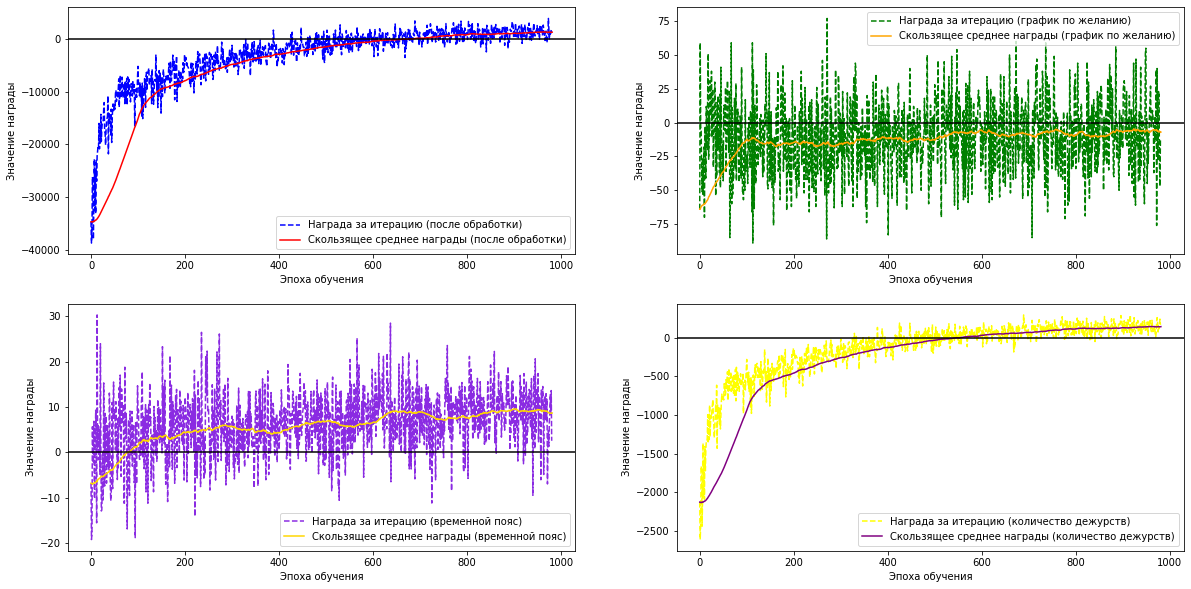

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
algorithm = REINFORCE(load_pretrained = False)

algorithm.train_algorithm(train_times = 10000)

По графикам видно, что модель обучается выбирать нужный результат, но обучается очень медленно и все равно не идеально. Это вполне ожидаемо, поскольку базовый алгоритм REINFORCE не совершенен, и обычно находит локальные минимумы вместо глобальных. 

На практике для подобных задач очень часто используют алгоритм Q-learning, однако хорошие результаты также дают более продвинутые политические алгоритмы, например «Преимущественный Актер-Критик» (Advantage Actor-Critic) и «Ближайшая Оптимизация Политики» (Рroximal Рolicy Optimization).

##Проверка работы модели

В конце урока применим обученную модель в инференсе. Для этого нужно установить тестовый режим `train_mode = False`, чтобы вместо предсказания вероятностей модель напрямую выбирала нужное действие.

In [ ]:
algorithm = REINFORCE(load_pretrained = True)

algorithm.environment.create_schedule(train_mode = False, episodes_in_batch = 1)

print(algorithm.environment.duty_timetable)

**Содержание темы**

1.  [Теория](https://colab.research.google.com/drive/1Qfic-ckzSmXUZ5pyQ7YDzE_gLq9hIA_T?usp=sharing)
2.  [Практический ноутбук 1](https://colab.research.google.com/drive/1fchXLLvAmJweE3kB00xJQazp2DiA_2Be?usp=sharing)
3. Практический ноутбук 2